In [1]:
import numpy as np
import matplotlib.pylab as plt
import glob
from matplotlib.ticker import ScalarFormatter
import ast
import h5py
from dynamic_extrusion_boundaries.lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
import dynamic_extrusion_boundaries.funcs as funcs
import cooltools
import cooltools.lib.plotting
%matplotlib inline

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### params

In [2]:
paramdict_CTCF = {
    'CTCF_facestall': [1],
    'CTCF_backstall': [0],
    'CTCF_lifetime': [1],
    'CTCF_offtime': [0.1],
    'LEF_lifetime': [500],
    'LEF_stalled_lifetime': [500],
    'LEF_birth': [0.1],
    'LEF_pause': [0.9],
    'LEF_separation': 300,
    'sites_per_monomer': 10,
    'monomers_per_replica': 1000,
    'number_of_replica': 1,
    'steps': 200,
    'velocity_multiplier': 1
}
TIME_CONV_COEF = 21.875 * 60 / 500 #to convert from lattice based to seconds
LATTICE_CONV_COEF = 0.25 #each lattice site is 0.25 kb

In [3]:
monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']
sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']

# Create some CTCF boundary sites
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
CTCF_right_positions = np.array(ctcfrightlist)
CTCF_left_positions = np.array(ctcfleftlist)

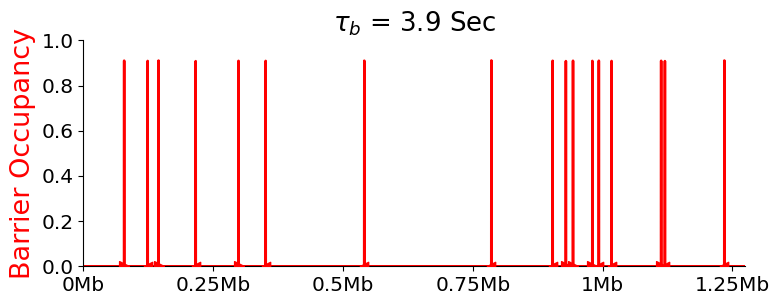

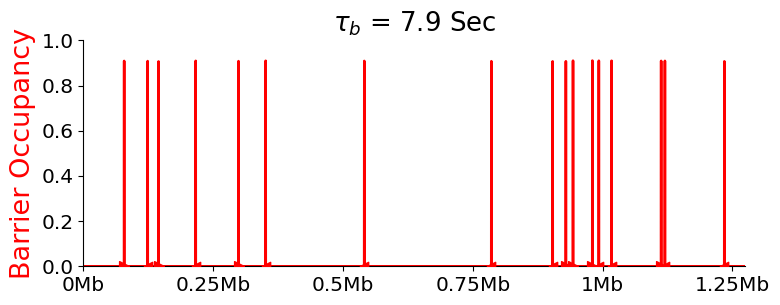

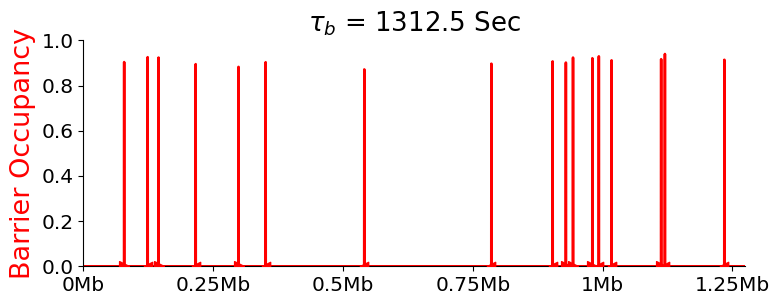

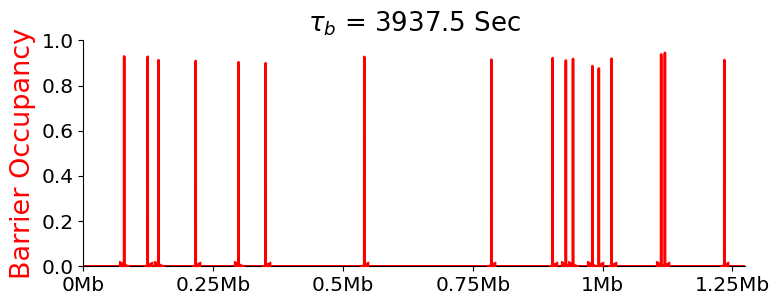

In [4]:
traj = 190000

velocity_range=[1]
lifetime_range = [500]
ctcf_life_range = [  1.5, 3.0, 500, 1500]
ctcf_oftime_range = [0.15, 0.3, 50, 150]
c=1

for lifetime_val in lifetime_range:
    for velocity_val in velocity_range:
        for ctcf_life in ctcf_life_range:    
            paramdict_CTCF['LEF_lifetime']=[lifetime_val, lifetime_val]
            paramdict_CTCF['velocity_multiplier'] = velocity_val
            paramdict_CTCF['LEF_stalled_lifetime']= [lifetime_val, lifetime_val]
            paramdict_CTCF['CTCF_lifetime']=[ctcf_life, ctcf_life]
            paramdict_CTCF['CTCF_offtime']=[ctcf_life/10, ctcf_life/10]
            
            ctcfrightarys = []
            ctcfleftarys = []
            translocator =funcs.make_translocator(LEFTranslocatorDynamicBoundary, 
                                                 site_types,
                                                 CTCF_left_positions,
                                                 CTCF_right_positions, 
                                                 **paramdict_CTCF)
            for _ in range(traj+1):
                translocator.step()
                ctcfrights = np.array(translocator.stallProbRight)
                ctcflefts = np.array(translocator.stallProbLeft)
                ctcfrightstrue = np.where(ctcfrights)[0]
                ctcfleftstrue = np.where(ctcflefts)[0]
                ctcfrightarys.append(ctcfrightstrue)
                ctcfleftarys.append(ctcfleftstrue)
            ctcfrightary = flattened_array = np.concatenate([arr.flatten() for arr in ctcfrightarys if arr.size > 0])
            ctcfleftary = flattened_array = np.concatenate([arr.flatten() for arr in ctcfleftarys if arr.size > 0])
            ctcfs = list(ctcfrightary)+list(ctcfleftary)
            a, b = np.histogram(ctcfs, np.arange(0,sites_per_replica,1))
            plt.figure(figsize = (7.91,3.15))
            plt.title(r'$\tau_b$ = %.1f Sec'%(ctcf_life*TIME_CONV_COEF),fontsize=18.75)
            plt.ylim(0,1)
            plt.xlim(100, 5100)
            plt.plot(a/traj, color = 'red',linewidth=1.85,alpha = 1)
            plt.scatter(ctcfrightlist,np.zeros(len(ctcfrightlist)),marker='>',color='red',s=50,zorder=3)
            plt.scatter(ctcfleftlist,np.zeros(len(ctcfleftlist)),marker='<',color='red',zorder=3)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.xticks(fontsize=14.5)
            plt.yticks(fontsize = 14.5)
            plt.xticks([0,1000,2000,3000,4000,5000])
            plt.gca().set_xticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])
            plt.ylabel('Barrier Occupancy',color='red',fontsize=19.5)
            plt.tight_layout()
            plt.savefig('../output/figures/ctcf_chip_tau_%s.pdf'%ctcf_life,transparent=True)
            plt.show()

### chipseq visualization for cohesins

In [5]:
path_dict = {}

directory='/project/fudenber_735/polychrom/Dynamic_boundary_model/1d_sims_dynamic_boundary/dynamical_boundary_simulations/sims/'

for fname  in glob.glob(directory+'folder*'):
    path_dict[fname.split('sims/')[1][:]]= fname
path_dict = dict(sorted(path_dict.items()))

In [6]:
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
ctcflist = np.array(ctcfrightlist + ctcfleftlist)


In [7]:
### list of boundary elements on all replications
rep = 10 
mon = 1000
site = 10
ctcf_list_t = []
for i in range(rep):
    ctcf_list_t += list(np.array(ctcflist)+i*mon*site)

In [8]:
def expand_peak_positions(boundary_list, window_sizes=[1]):
    """
    Calculate peak positions based on a boundary_list within window_sizes.

    Args:
        boundary_list (list): List of boundary values.
        window_sizes (list, optional): List of window sizes. Defaults to [1].

    Returns:
        np.ndarray: Array containing peak positions.
    """
    peak_monomers = np.array([])

    for i in window_sizes:
        inds_to_add = [boundary + i for boundary in boundary_list]
        peak_monomers = np.hstack((peak_monomers, inds_to_add))

    return peak_monomers.astype(int)

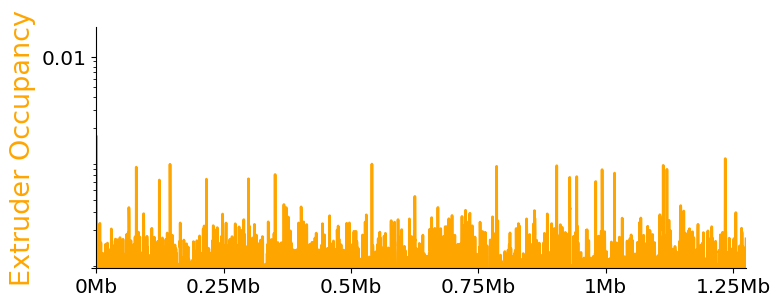

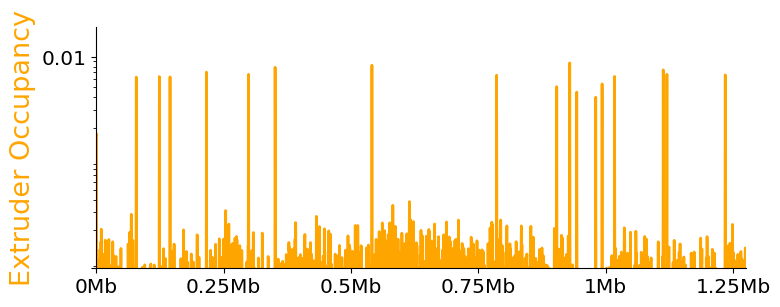

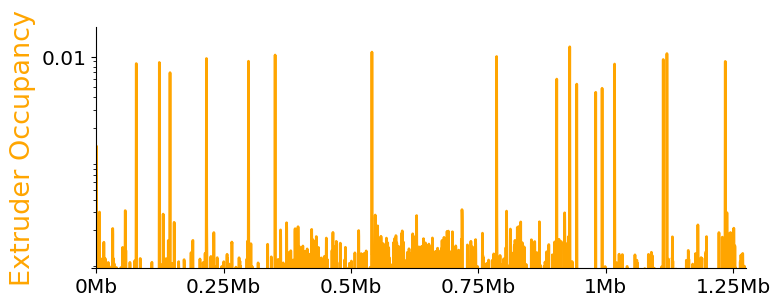

In [9]:
window_size = 1
numx,numy = 1,len(path_dict)
min_time = -500000
c=0
hist_dict = {}
invs_dict = ['folder_face_1.0_back_0_Clife_3.0_Cof_0.3_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
             'folder_face_1.0_back_0_Clife_500.0_Cof_50.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
            'folder_face_1.0_back_0_Clife_1500.0_Cof_150.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
            ]

for name in invs_dict:
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params

    c+=1

    mapN = mon*site
    lefs = h5py.File(path_dict[name]+'/LEFPositions.h5','r')["positions"]
    
    
    lef_lefts = lefs[min_time:,:,0].flatten()
    lef_rights = lefs[min_time:,:,1].flatten()
    lef_positions = np.hstack((lef_lefts,lef_rights))

    peak_monomers = expand_peak_positions(ctcf_list_t,window_sizes=np.arange(-window_size,(window_size)+1) )

    plt.figure(figsize = (7.915,3))
    a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
    plt.plot(a[:]/np.sum(a), label=name,color='orange',linewidth=1.95)
    
    hist_dict[name] = a/np.sum(a)
    
    plt.yscale('log')
    plt.ylim([0.000085,.0195])
    plt.xlim(100,5100)
    # Hide frame on the right and top axes
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.xticks(fontsize=14.5)
    plt.yticks(fontsize = 14.5)
    plt.xticks([0,1000,2000,3000,4000,5000])
    plt.yticks([0.000085,.01])
    plt.gca().set_xticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])
    plt.gca().set_yticklabels(['','0.01'])
    plt.ylabel('Extruder Occupancy',color='orange',fontsize=19.5)
    plt.tight_layout()
    plt.savefig('../output/figures/extchipseq_for_%s.pdf'%clife,transparent=True)
    plt.show()


folder_face_1.0_back_0_Clife_1500.0_Cof_150.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1


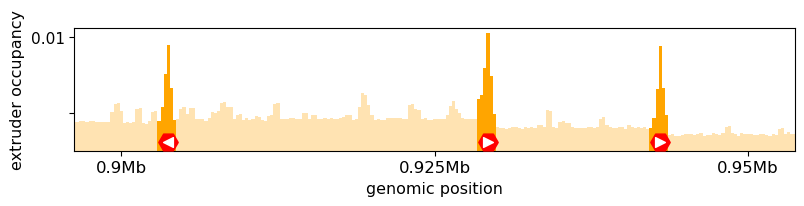

In [10]:
window_size = 1
numx,numy = 1,len(path_dict)
min_time = -500000
hist_dict = {}
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
invs_dict = ['folder_face_1.0_back_0_Clife_1500.0_Cof_150.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1']

for name in invs_dict:
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    
    mapN=mon*site
    lefs = h5py.File(path_dict[name]+'/LEFPositions.h5','r')["positions"]
    lef_lefts = lefs[min_time:,:,0].flatten()
    lef_rights = lefs[min_time:,:,1].flatten()
    lef_positions = np.hstack((lef_lefts,lef_rights))

    peak_monomers = expand_peak_positions(ctcf_list_t,window_sizes=np.arange(-window_size,(window_size)+1) )

    plt.figure(figsize = (8.15,1.985))
    a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))

    x=np.arange(len(a))
    y = x
    plt.bar(np.arange(len(a)),a/np.sum(a), color='orange', alpha=0.3, width = 1)
    for i in range(len(ctcflist)):
        newy=y[ctcflist[i]-3:ctcflist[i]+3]
        plt.bar(newy, a[ctcflist[i]-3:ctcflist[i]+3]/np.sum(a), color ='orange',width=1)
    plt.scatter(ctcfrightlist,np.zeros(len(ctcfrightlist))+0.0000138,marker='H',color='red',s=195,zorder=3)
    plt.scatter(ctcfleftlist,np.zeros(len(ctcfleftlist))+0.0000138,marker='H',color='red',s=195,zorder=3)
    plt.scatter(ctcfrightlist,np.zeros(len(ctcfrightlist))+0.0000138,marker='>',color='white',s=50,zorder=3)
    plt.scatter(ctcfleftlist,np.zeros(len(ctcfleftlist))+0.0000138,marker='<',color='white',s=50,zorder=3)

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().tick_params(axis='y', which='minor', left=False)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.3g}'))

    plt.yscale('log')
    hist_dict[name] = a/np.sum(a)
    plt.ylabel('extruder occupancy', fontsize = 11.5)
    plt.xlabel('genomic position', fontsize=11.5)
    plt.xticks([0, 1000, 2000, 3000, 3600, 3700, 3800, 4000, 5000, 6000, 8000, 10000], fontsize =11.95)
    plt.yticks([0.000085,.01], fontsize =11)
    plt.xlim(3585, 3815)
    plt.gca().set_yticklabels(['','0.01'])
    plt.gca().set_xticklabels(['0Mb',  '0.25Mb', '0.5Mb', '0.75Mb', '0.9Mb','0.925Mb', '0.95Mb', '1Mb', '125Mb','1.5Mb', '2Mb','2.5Mb'])
    # Hide frame on the right and top axes
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.tight_layout()
    #plt.savefig('./repo_for_dynamic/output/figures/chipseq_for_sample.pdf', transparent= True)
    plt.show()
